<a href="https://colab.research.google.com/github/fAikoH-dot/TCC-v1/blob/main/prophet/prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
# !pip install prophet

In [16]:
%pip install python-bcb

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error

In [18]:
df = pd.read_csv('../../data library/Trigo_v1.csv', sep=";")
df = df.sort_values(by='Data').reset_index(drop=True)
df.rename(columns={"Data":"ds", "Estadual":"y"}, inplace=True)
df.head()

,ds,Cultivo,y,País,Id,Último,Abertura,Máxima,Mínima
0,2004-03-01,Trigo,25.0014,24.2907,2,38150.0,40825.0,42400.0,36600.0
1,2004-04-01,Trigo,27.3438,26.4508,2,36200.0,38050.0,40700.0,35400.0
2,2004-05-01,Trigo,29.6849,28.6268,2,33800.0,36500.0,39100.0,0.0
3,2004-06-01,Trigo,30.2614,29.9106,2,31225.0,33525.0,34800.0,31000.0
4,2004-07-01,Trigo,27.5388,27.7931,2,30975.0,31075.0,32400.0,29550.0


In [19]:
from bcb import PTAX
from bcb import currency

ptax = PTAX()

df_usd = currency.get(['USD'],
                  start='2004-03-01',
                  end='2024-09-01',
                  side='ask')

df_usd["Date"]=df_usd.index
df_usd["Month"] = df_usd["Date"].dt.month
df_usd["Year"] = df_usd["Date"].dt.year
df_usd["Day"] = 1
df_usd["Aux"] = df_usd["Year"].astype(str) +"-"+ df_usd["Month"].astype(str)
df_usd = df_usd.groupby("Aux").agg(
    USD = ("USD", "mean"),
    day = ("Day", "first"),
    month = ("Month", "first"),
    year = ("Year", "first"),
).reset_index(drop=True)

df_usd["Data"] = pd.to_datetime(df_usd[['year', 'month', 'day']])
df_usd = df_usd[["Data", "USD"]].sort_values(by="Data").reset_index(drop=True)

In [20]:
clima = pd.read_csv("../../data library/Clima/MT_dados.csv", sep=';')
clima.rename(columns={"PRECIPITACAO TOTAL":"precipitacao", "TEMPERATURA MEDIA":"temperatura"}, inplace=True)

clima["precipitacao"] = clima.precipitacao.str.replace(',', '.')
clima["temperatura"] = clima.temperatura.str.replace(',', '.')

clima.bfill(inplace=True)
clima.head()

,Data Medicao,precipitacao,temperatura
0,31/03/2004,175.4,24.9
1,30/04/2004,175.4,24.5
2,31/05/2004,23,21.7
3,30/06/2004,18.8,22.1
4,31/07/2004,38,22.2


In [21]:
df["USD"] = df_usd["USD"]
df["Precipitacao"] = clima["precipitacao"].astype(float)
df["Temperatura"] = clima["temperatura"].astype(float)
df['lag_Estadual'] = df['y'].shift(1)
df['lag_Estadual'] = df['lag_Estadual'].bfill()
df.head()

,ds,Cultivo,y,País,Id,Último,Abertura,Máxima,Mínima,USD,Precipitacao,Temperatura,lag_Estadual
0,2004-03-01,Trigo,25.0014,24.2907,2,38150.0,40825.0,42400.0,36600.0,2.905457,175.4,24.9,25.0014
1,2004-04-01,Trigo,27.3438,26.4508,2,36200.0,38050.0,40700.0,35400.0,2.905985,175.4,24.5,25.0014
2,2004-05-01,Trigo,29.6849,28.6268,2,33800.0,36500.0,39100.0,0.0,3.100419,23.0,21.7,27.3438
3,2004-06-01,Trigo,30.2614,29.9106,2,31225.0,33525.0,34800.0,31000.0,3.129148,18.8,22.1,29.6849
4,2004-07-01,Trigo,27.5388,27.7931,2,30975.0,31075.0,32400.0,29550.0,3.036777,38.0,22.2,30.2614


In [22]:
def plot_predictions(testing_dates, y_test, prediction):
    df_test = pd.DataFrame({"date": testing_dates, "actual": y_test, "prediction": prediction })
    _, ax = plt.subplots(figsize=(10, 5))
    df_test.plot(ax=ax, label="Actual", x="date", y="actual")
    df_test.plot(ax=ax, label="Prediction", x="date", y="prediction")
    plt.legend(["Actual", "Prediction"])
    plt.show()

In [23]:
def evaluate_model(y_test, prediction):
  print(f"MAE: {mean_absolute_error(y_test, prediction)}")
  print(f"RMSE: {root_mean_squared_error(y_test, prediction)}")
  print(f"MAPE: {mean_absolute_percentage_error(y_test, prediction)}")
  print(f"R-Squared: {r2_score(y_test, prediction)}")

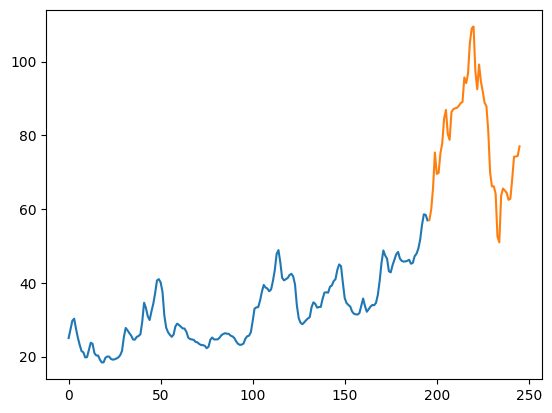

In [24]:
train_size = int(len(df) * 0.8)
train, test = df[0:train_size], df[train_size:len(df)]

test_dates = test.ds

plt.plot(train.y)
plt.plot(test.y)

# Univariado

In [25]:
m = Prophet()
m.fit(train)

# m.params

23:32:41 - cmdstanpy - INFO - Chain [1] start processing
23:32:41 - cmdstanpy - INFO - Chain [1] done processing


In [26]:
forecast = m.predict(test)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2020-08-01,47.103508,40.035817,54.227022
1,2020-09-01,46.963269,39.631995,53.676174
2,2020-10-01,46.515498,39.365997,53.990570
3,2020-11-01,46.324296,39.373269,53.585536
4,2020-12-01,46.365536,39.305157,53.337386


In [27]:
test.reset_index(inplace=True, drop=True)
final_df = test[["ds", "y"]].copy()
final_df['yhat'] = forecast['yhat']
final_df.head()

,ds,y,yhat
0,2020-08-01,56.9863,47.103508
1,2020-09-01,59.8474,46.963269
2,2020-10-01,65.6995,46.515498
3,2020-11-01,75.3144,46.324296
4,2020-12-01,69.5309,46.365536


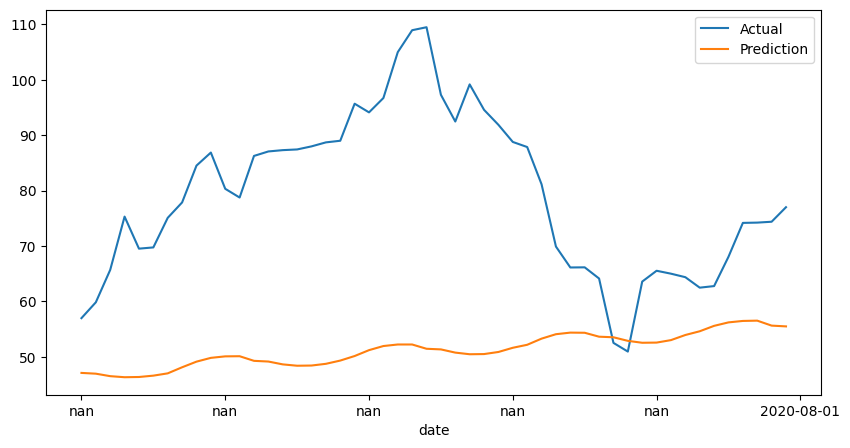

MAE: 28.059207285699078
RMSE: 31.808743924030985
MAPE: 0.33116291990158353
R-Squared: -3.876990331199913


In [28]:
plot_predictions(test_dates, final_df.y, final_df.yhat)
evaluate_model(final_df.y, final_df.yhat)

# Multivariado

In [29]:
m = Prophet()
m.add_regressor('USD')
m.add_regressor('País')
m.add_regressor('Último')
m.add_regressor('Máxima')
m.add_regressor('lag_Estadual')
m.fit(train)

# m.params

23:32:42 - cmdstanpy - INFO - Chain [1] start processing
23:32:42 - cmdstanpy - INFO - Chain [1] done processing


In [30]:
test_1 = test[['ds', 'USD', 'País', 'Último', 'Máxima', 'lag_Estadual']]
test_1.head()

,ds,USD,País,Último,Máxima,lag_Estadual
0,2020-08-01,5.280191,56.1960,54650.0,55175.0,56.9056
1,2020-09-01,5.461233,58.5133,57812.0,58662.0,56.9863
2,2020-10-01,5.399486,66.6685,59850.0,63762.0,59.8474
3,2020-11-01,5.625790,77.1260,58100.0,62588.0,65.6995
4,2020-12-01,5.417835,70.0093,64175.0,64438.0,75.3144


In [31]:
# future = m.make_future_dataframe(periods=len(test_1), freq='MS')
# future.head()

In [32]:
forecast = m.predict(test_1)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2020-08-01,60.793005,59.423928,62.217656
1,2020-09-01,62.306689,60.901682,63.727539
2,2020-10-01,69.364910,67.984988,70.830303
3,2020-11-01,79.480007,77.882903,80.875991
4,2020-12-01,78.080467,76.754826,79.609525


In [33]:
test.reset_index(inplace=True, drop=True)
final_df = test[["ds", "y", "País", "USD"]].copy()
final_df['yhat'] = forecast['yhat']
final_df.head()

,ds,y,País,USD,yhat
0,2020-08-01,56.9863,56.1960,5.280191,60.793005
1,2020-09-01,59.8474,58.5133,5.461233,62.306689
2,2020-10-01,65.6995,66.6685,5.399486,69.364910
3,2020-11-01,75.3144,77.1260,5.625790,79.480007
4,2020-12-01,69.5309,70.0093,5.417835,78.080467


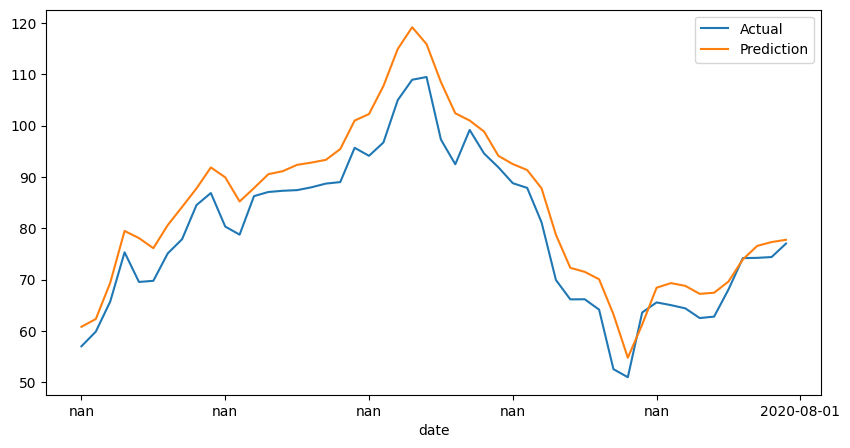

MAE: 5.221005733881402
RMSE: 5.910861505480423
MAPE: 0.06683076381849266
R-Squared: 0.8315928902936627


In [34]:
plot_predictions(test_dates, final_df.y, final_df.yhat)
evaluate_model(final_df.y, final_df.yhat)

In [35]:
aux_var = ['USD', 'País', 'Último', 'Máxima', 'lag_Estadual']
future_dates = m.make_future_dataframe(periods=((len(test_1))+24), freq="MS")

In [36]:
extended_df = future_dates.copy()

for i in aux_var:
    train_aux = train[['ds', i]].copy()
    train_aux.rename(columns={i:"y"}, inplace=True)

    m = Prophet()
    m.fit(train_aux)
    forecast = m.predict(future_dates)
    
    extended_df[i] = forecast["yhat"]

extended_df

23:32:42 - cmdstanpy - INFO - Chain [1] start processing
23:32:42 - cmdstanpy - INFO - Chain [1] done processing
23:32:43 - cmdstanpy - INFO - Chain [1] start processing
23:32:43 - cmdstanpy - INFO - Chain [1] done processing
23:32:43 - cmdstanpy - INFO - Chain [1] start processing
23:32:43 - cmdstanpy - INFO - Chain [1] done processing
23:32:43 - cmdstanpy - INFO - Chain [1] start processing
23:32:43 - cmdstanpy - INFO - Chain [1] done processing
23:32:44 - cmdstanpy - INFO - Chain [1] start processing
23:32:44 - cmdstanpy - INFO - Chain [1] done processing


,ds,USD,País,Último,Máxima,lag_Estadual
0,2004-03-01,2.814078,22.320326,37566.407032,32257.652450,20.982133
1,2004-04-01,2.785586,22.996572,37006.749529,39906.590390,21.263231
2,2004-05-01,2.809846,23.701273,37168.507239,40210.643685,22.259508
3,2004-06-01,2.843009,24.097087,37906.169625,42078.515645,22.858772
4,2004-07-01,2.775656,24.166304,40074.204541,42843.681718,23.115668
...,...,...,...,...,...,...
265,2026-05-01,6.227675,57.556133,28266.840949,31110.152375,59.422399
266,2026-06-01,6.277252,57.868359,27819.834562,32114.341744,60.141168
267,2026-07-01,6.269313,57.791281,28682.189636,32078.886050,60.396179
268,2026-08-01,6.228821,57.217157,28776.430617,32776.306695,59.879047


In [37]:
m = Prophet()
m.add_regressor('USD')
m.add_regressor('País')
m.add_regressor('Último')
m.add_regressor('Máxima')
m.add_regressor('lag_Estadual')
m.fit(train)

23:32:44 - cmdstanpy - INFO - Chain [1] start processing
23:32:44 - cmdstanpy - INFO - Chain [1] done processing


In [38]:
real_data = df[['ds', 'USD', 'País', 'Último', 'Máxima', 'lag_Estadual']].copy()
final_date = df["ds"][-1:]
predicted_data = extended_df[['ds', 'USD', 'País', 'Último', 'Máxima', 'lag_Estadual']][len(train)+len(test):]

real_data_2 = pd.concat([real_data, predicted_data], ignore_index=True)

In [39]:
test_2 = real_data_2[['ds', 'USD', 'País', 'Último', 'Máxima', 'lag_Estadual']][train_size:].reset_index(drop=True)
test_2.head()

,ds,USD,País,Último,Máxima,lag_Estadual
0,2020-08-01,5.280191,56.1960,54650.0,55175.0,56.9056
1,2020-09-01,5.461233,58.5133,57812.0,58662.0,56.9863
2,2020-10-01,5.399486,66.6685,59850.0,63762.0,59.8474
3,2020-11-01,5.625790,77.1260,58100.0,62588.0,65.6995
4,2020-12-01,5.417835,70.0093,64175.0,64438.0,75.3144


In [40]:
final_forecast = m.predict(test_2)
final_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2020-08-01,60.793005,59.379672,62.162006
1,2020-09-01,62.306689,60.915829,63.711625
2,2020-10-01,69.364910,67.962744,70.760370
3,2020-11-01,79.480007,77.964866,80.808773
4,2020-12-01,78.080467,76.756263,79.412810


In [41]:
test_2.reset_index(inplace=True, drop=True)
test_2['y'] = test['y']
test_2.fillna(0, inplace=True)
final_df = test_2[["ds", "y", "País", "USD"]].copy()
final_df['yhat'] = final_forecast['yhat']
final_df.head()

,ds,y,País,USD,yhat
0,2020-08-01,56.9863,56.1960,5.280191,60.793005
1,2020-09-01,59.8474,58.5133,5.461233,62.306689
2,2020-10-01,65.6995,66.6685,5.399486,69.364910
3,2020-11-01,75.3144,77.1260,5.625790,79.480007
4,2020-12-01,69.5309,70.0093,5.417835,78.080467


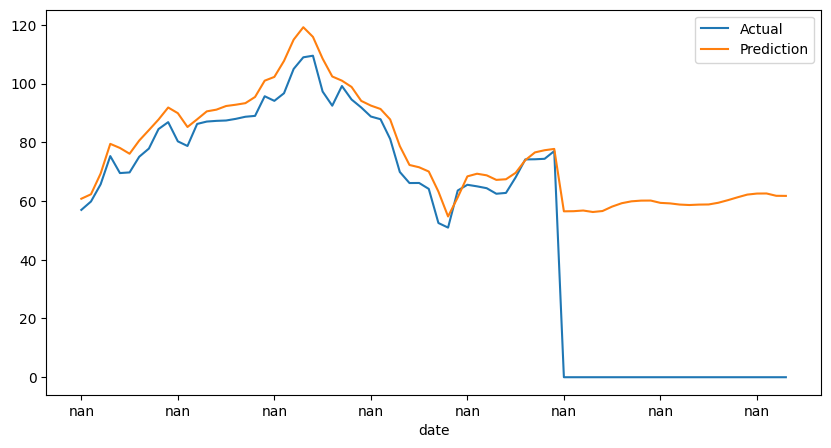

MAE: 22.79635232165956
RMSE: 34.199345255085746
MAPE: 8.677826579582205e+16
R-Squared: 0.22754632086017346


In [42]:
plot_predictions(test_dates, final_df.y, final_df.yhat)
evaluate_model(final_df.y, final_df.yhat)

In [43]:
final_df.to_csv('../../Trigo/Trigo_Resultados.csv', sep=',', index=False)